<a href="https://colab.research.google.com/github/xuebingwu/SplicingLab/blob/main/scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <font color='MediumSlateBlue '> **Splicing^Lab**  </font> 
## A Colab notebook for predicting 5' and 3' splice sites from a single sequence
---
[Xuebing Wu lab @ Columbia](https://xuebingwu.github.io/)     |     [GitHub repository](https://github.com/xuebingwu/splice-site-prediction-with-pangolin) 




OUTPUT


2023-05-09 17:35:38: Input sequence length = 786
2023-05-09 17:35:38: Loading models
2023-05-09 17:35:38: Scoring sites: + strand
2023-05-09 17:35:41: Filtering sites: + strand
3 splice sites found on the + strand with SCORE_CUTOFF = 0.2
2023-05-09 17:35:41: Saving to file: + strand


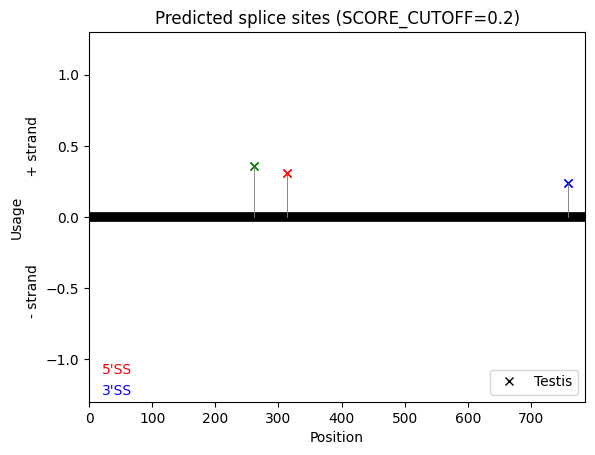


---------------------------------
#Predicted splice sites
#Options: SCORE_TYPE=Usage, SCORE_CUTOFF=0.2
#Columns info:
#1 - Position: site position in the sequence
#2 - Sequence: 20-nt junction sequence. Intron-lower case; Exon-upper case
#3 - Strand: strand of the site
#4 - Type: 5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical
#5-8 - Scores: site usage or P(splice) in each tissue

Position	Sequence	Strand	Type	Testis
261	TTCCTTACAGGGTTTTAGAC	+	Undetermined	0.36
314	TAAATTAAGGAgtaagtctg	+	5'SS	0.306
759	tcatttgcagGAAATGCTGG	+	3'SS	0.239


In [34]:
#@title Step 1: Predict splice sites

# scripts from custom_usage.py from the Pangolin package

import os
from matplotlib import pylab
import matplotlib.lines as mlines
from google.colab import files
import datetime
import re


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

########## input 
INPUT = "SMN2 exon 7"#@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR reporter","SMN2 exon 7"] {allow-input: true}
#INPUT = "Paste your sequence or select a sample sequence (default: ACTB pre-mRNA)"#@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR reporter"] {allow-input: true}

#@markdown - To run: click `Runtime` -> `Run all` in the menu bar, or click the triangle play/run button on the left
#@markdown - Input format: raw sequence (A/C/G/T/U only); space allowed
#@markdown - Example: copy & paste a multi-line sequence from a FASTA file (without the header), or entire plasmid sequence from Snapgene or Benchling 

seq = INPUT

if seq == "ACTB pre-mRNA":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
elif seq == "GAPDH pre-mRNA":
  seq = "GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGCCAGGTGAAGACGGGCGGAGAGAAACCCGGGAGGCTAGGGACGGCCTGAAGGCGGCAGGGGCGGGCGCAGGCCGGATGTGTTCGCGCCGCTGCGGGGTGGGCCCGGGCGGCCTCCGCATTGCAGGGGCGGGCGGAGGACGTGATGCGGCGCGGGCTGGGCATGGAGGCCTGGTGGGGGAGGGGAGGGGAGGCGTGTGTGTCGGCCGGGGCCACTAGGCGCTCACTGTTCTCTCCCTCCGCGCAGCCGAGCCACATCGCTCAGACACCATGGGGAAGGTGAAGGTCGGAGTCAACGGGTGAGTTCGCGGGTGGCTGGGGGGCCCTGGGCTGCGACCGCCCCCGAACCGCGTCTACGAGCCTTGCGGGCTCCGGGTCTTTGCAGTCGTATGGGGGCAGGGTAGCTGTTCCCCGCAAGGAGAGCTCAAGGTCAGCGCTCGGACCTGGCGGAGCCCCGCACCCAGGCTGTGGCGCCCTGTGCAGCTCCGCCCTTGCGGCGCCATCTGCCCGGAGCCTCCTTCCCCTAGTCCCCAGAAACAGGAGGTCCCTACTCCCGCCCGAGATCCCGACCCGGACCCCTAGGTGGGGGACGCTTTCTTTCCTTTCGCGCTCTGCGGGGTCACGTGTCGCAGAGGAGCCCCTCCCCCACGGCCTCCGGCACCGCAGGCCCCGGGATGCTAGTGCGCAGCGGGTGCATCCCTGTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAAGGAAATGAATGGGCAGCCGTTAGGAAAGCCTGCCGGTGACTAACCCTGCGCTCCTGCCTCGATGGGTGGAGTCGCGTGTGGCGGGGAAGTCAGGTGGAGCGAGGCTAGCTGGCCCGATTTCTCCTCCGGGTGATGCTTTTCCTAGATTATTCTCTGGTAAATCAAAGAAGTGGGTTTATGGAGGTCCTCTTGTGTCCCCTCCCCGCAGAGGTGTGGTGGCTGTGGCATGGTGCCAAGCCGGGAGAAGCTGAGTCATGGGTAGTTGGAAAAGGACATTTCCACCGCAAAATGGCCCCTCTGGTGGTGGCCCCTTCCTGCAGCGCCGGCTCACCTCACGGCCCCGCCCTTCCCCTGCCAGCCTAGCGTTGACCCGACCCCAAAGGCCAGGCTGTAAATGTCACCGGGAGGATTGGGTGTCTGGGCGCCTCGGGGAACCTGCCCTTCTCCCCATTCCGTCTTCCGGAAACCAGATCTCCCACCGCACCCTGGTCTGAGGTTAAATATAGCTGCTGACCTTTCTGTAGCTGGGGGCCTGGGCTGGGGCTCTCTCCCATCCCTTCTCCCCACACACATGCACTTACCTGTGCTCCCACTCCTGATTTCTGGAAAAGAGCTAGGAAGGACAGGCAACTTGGCAAATCAAAGCCCTGGGACTAGGGGGTTAAAATACAGCTTCCCCTCTTCCCACCCGCCCCAGTCTCTGTCCCTTTTGTAGGAGGGACTTAGAGAAGGGGTGGGCTTGCCCTGTCCAGTTAATTTCTGACCTTTACTCCTGCCCTTTGAGTTTGATGATGCTGAGTGTACAAGCGTTTTCTCCCTAAAGGGTGCAGCTGAGCTAGGCAGCAGCAAGCATTCCTGGGGTGGCATAGTGGGGTGGTGAATACCATGTACAAAGCTTGTGCCCAGACTGTGGGTGGCAGTGCCCCACATGGCCGCTTCTCCTGGAAGGGCTTCGTATGACTGGGGGTGTTGGGCAGCCCTGGAGCCTTCAGTTGCAGCCATGCCTTAAGCCAGGCCAGCCTGGCAGGGAAGCTCAAGGGAGATAAAATTCAACCTCTTGGGCCCTCCTGGGGGTAAGGAGATGCTGCATTCGCCCTCTTAATGGGGAGGTGGCCTAGGGCTGCTCACATATTCTGGAGGAGCCTCCCCTCCTCATGCCTTCTTGCCTCTTGTCTCTTAGATTTGGTCGTATTGGGCGCCTGGTCACCAGGGCTGCTTTTAACTCTGGTAAAGTGGATATTGTTGCCATCAATGACCCCTTCATTGACCTCAACTACATGGTGAGTGCTACATGGTGAGCCCCAAAGCTGGTGTGGGAGGAGCCACCTGGCTGATGGGCAGCCCCTTCATACCCTCACGTATTCCCCCAGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTCAAGGCTGAGAACGGGAAGCTTGTCATCAATGGAAATCCCATCACCATCTTCCAGGAGTGAGTGGAAGACAGAATGGAAGAAATGTGCTTTGGGGAGGCAACTAGGATGGTGTGGCTCCCTTGGGTATATGGTAACCTTGTGTCCCTCAATATGGTCCTGTCCCCATCTCCCCCCCACCCCCATAGGCGAGATCCCTCCAAAATCAAGTGGGGCGATGCTGGCGCTGAGTACGTCGTGGAGTCCACTGGCGTCTTCACCACCATGGAGAAGGCTGGGGTGAGTGCAGGAGGGCCCGCGGGAGGGGAAGCTGACTCAGCCCTGCAAAGGCAGGACCCGGGTTCATAACTGTCTGCTTCTCTGCTGTAGGCTCATTTGCAGGGGGGAGCCAAAAGGGTCATCATCTCTGCCCCCTCTGCTGATGCCCCCATGTTCGTCATGGGTGTGAACCATGAGAAGTATGACAACAGCCTCAAGATCATCAGGTGAGGAAGGCAGGGCCCGTGGAGAAGCGGCCAGCCTGGCACCCTATGGACACGCTCCCCTGACTTGCGCCCCGCTCCCTCTTTCTTTGCAGCAATGCCTCCTGCACCACCAACTGCTTAGCACCCCTGGCCAAGGTCATCCATGACAACTTTGGTATCGTGGAAGGACTCATGGTATGAGAGCTGGGGAATGGGACTGAGGCTCCCACCTTTCTCATCCAAGACTGGCTCCTCCCTGCCGGGGCTGCGTGCAACCCTGGGGTTGGGGGTTCTGGGGACTGGCTTTCCCATAATTTCCTTTCAAGGTGGGGAGGGAGGTAGAGGGGTGATGTGGGGAGTACGCTGCAGGGCCTCACTCCTTTTGCAGACCACAGTCCATGCCATCACTGCCACCCAGAAGACTGTGGATGGCCCCTCCGGGAAACTGTGGCGTGATGGCCGCGGGGCTCTCCAGAACATCATCCCTGCCTCTACTGGCGCTGCCAAGGCTGTGGGCAAGGTCATCCCTGAGCTGAACGGGAAGCTCACTGGCATGGCCTTCCGTGTCCCCACTGCCAACGTGTCAGTGGTGGACCTGACCTGCCGTCTAGAAAAACCTGCCAAATATGATGACATCAAGAAGGTGGTGAAGCAGGCGTCGGAGGGCCCCCTCAAGGGCATCCTGGGCTACACTGAGCACCAGGTGGTCTCCTCTGACTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGCATTGCCCTCAACGACCACTTTGTCAAGCTCATTTCCTGGTATGTGGCTGGGGCCAGAGACTGGCTCTTAAAAAGTGCAGGGTCTGGCGCCCTCTGGTGGCTGGCTCAGAAAAAGGGCCCTGACAACTCTTTTCATCTTCTAGGTATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGGCCTCCAAGGAGTAAGACCCCTGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGAGACCCTCACTGCTGGGGAGTCCCTGCCACACTCAGTCCCCCACCACACTGAATCTCCCCTCCTCACAGTTGCCATGTAGACCCCTTGAAGAGGGGAGGGGCCTAGGGAGCCGCACCTTGTCATGTACCATCAATAAAGTACCCTGTGCTCAACCA"
elif seq == "EGFP + CENPB 3' UTR reporter":
  seq = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAAGTCACTGGACCTAGCTGTGCCCCCAACCTAGATTGGCAGCACCACCCCAGGGCAGAGGACTCTCTGGGCACCCGCTGTGCATGGAGCCAGAGTGCAGAGCCCCAGATCCTTTAGTAATGCTTCCCCTGGTCCTGCAACAGGCCCGGTCACCTCGGCCGGGCCCGGGGCTGAGGTCAGCCTCACTGCCTGCTTATTGCCTCTTTCTCAGAATCCTCTTTCCTCCCCATTTGGCCCTGGGCTCAGGGGACCAGGTGGGGCGGGTGGGGAGCTGTCCGGTGCTACCACACCGTGCCCTCAGTGGACTAACCACAGCAGCAGCCAGGGATGGGCCCTGGAGGTTCCCGGCCGGAGAGTGCCTCTCCCCTCTGCCATCCACGTCAGGTCTTTGGTGGGGGGACCCCAAAGCCATTCTGGGAAGGGCTCCAGAAGAAGGTCCAGCCTAGGCCCCCTGCAAGGCTGGCAGCCCCCACCCCCACCCCCCAGGCCGCCTTGAGAAGCACAGTTTAACTCACTGCGGGCTCCTGAGCCTGCTTCTGCCTGCTTTCCACCTCCCCAGTCCCTTTCTCTGGCCCTGTCCATGTGACTTTGGCCCTTGGTTTTCTTTCCAGATTGGAGGTTTCCAAGAGGCCCCCCACCGTGGAAGTAACCAAGGGCGCTTCCTTGTGGGCAGCTGCAGGCCCCATGCCTCTCCTCCCTCTCTGGCAGGGCCCCATCCTGGGCAGAGGGGCCTGGGGCTGGGCCCAGAGTCCAGCCGTCCAGCTGCTCCTTTCCCAGTTTGATTTCAATAAATCTGTCCACTCCCCTTTTGTGGGGGTGAACGTTTTAACAGCCAAGGGT"
elif seq == "SMN2 exon 7":
  seq="CGCCTCCCAAAGTTGTGGGATTGTAGGCATGAGCCACTGCAAGAAAACCTTAACTGCAGCCTAATAATTGTTTTCTTTGGGATAACTTTTAAAGTACATTAAAAGACTATCAACTTAATTTCTGATCATATTTTGTTGAATAAAATAAGTAAAATGTCTTGTGAAACAAAATGCTTTTTAACATCCATATAAAGCTATCTATATATAGCTATCTATATCTATATAGCTATTTTTTTTAACTTCCTTTATTTTCCTTACAGGGTTTTAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTCCTTAAATTAAGGAGTAAGTCTGCCAGCATTATGAAAGTGAATCTTACTTTTGTAAAACTTTATGGTTTGTGGAAAACAAATGTTTTTGAACATTTAAAAAGTTCAGATGTTAGAAAGTTGAAAGGTTAATGTAAAACAATCAATATTAAAGAATTTTGATGCCAAAACTATTAGATAAAAGGTTAATCTACATCCCTACTAGAATTCTCATACTTAACTGGTTGGTTGTGTGGAAGAAACATACTTTCACAATAAAGAGCTTTAGGATATGATGCCATTTTATATCACTAGTAGGCAGACCAGCAGACTTTTTTTTATTGTGATATGGGATAACCTAGGCATACTGCACTGTACACTCTGACATATGAAGTGCTCTAGTCAAGTTTAACTGGTGTCCACAGAGGACATGGTTTAACTGGAATTCGTCAAGCCTCTGGTTCTAATTTCTCATTTGCAGGAAATGCTGGCATAGAGCAGCACTAAAT"
elif seq == "Paste your sequence or select a sample sequence (default: ACTB pre-mRNA)":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
else: # user input 
  # clean up sequence: upper case, remove space, RNA->DNA
  seq = seq.upper().replace('U','T').replace(' ','')
  # if contains non ACGT letters:
  if not all(char in 'ACGT' for char in seq):
    print("\n\n")
    print('\n'+ bcolors.BOLD +bcolors.FAIL + "WARNING: Your sequence contains non A/C/G/T letters!"+bcolors.ENDC)
    L0  = len(seq)
    seq = re.sub('[^ACGT]+', '', seq)
    L1 = len(seq)
    print(L0-L1,'non A/C/G/T base(s) removed!'+bcolors.ENDC)
    exit()


print('\n\n'+ bcolors.BOLD +bcolors.OKBLUE + "OUTPUT"  +bcolors.ENDC)

######### options

# set model type
SCORE_TYPE = "Usage" #@param ["Usage", "P(splice)"]
#@markdown - *Usage*: predict tissue-specific usage of a splice site (default).  
#@markdown - *P(splice)*: predict tissue-specific probability of a site being spliced

if SCORE_TYPE == "Usage":
  model_nums = [7]
else:
  model_nums = [6]
# 0 = Heart, P(splice)
# 1 = Heart, usage
# 2 = Liver, P(splice)
# 3 = Liver, usage
# 4 = Brain, P(splice)
# 5 = Brain, usage
# 6 = Testis, P(splice)
# 7 = Testis, usage

tissues = ['Testis']

# min score
SCORE_CUTOFF = 0.2 #@param {type:"slider", min:0.01, max:1, step:0.01}
#@markdown - Minimum usage/splicing probability of a site to be included in the output 
#@markdown - A site is included if it meets the cutoff in any of the four tissues: heart, liver, brain, and testis 

if not os.path.exists("SplicingLab"):
  print("\n")
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Loading Pangolin (~30s, first time only)')
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  #!pip install pyvcf gffutils biopython pandas pyfastx
  !git clone https://github.com/xuebingwu/SplicingLab.git
  %cd SplicingLab
  !pip install .
  %cd /content
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

from pkg_resources import resource_filename
from pangolin.model import *

# Load models
def load_models(model_nums):
    models = []
    for i in model_nums:
        for j in range(1, 6):
            model = Pangolin(L, W, AR)
            if torch.cuda.is_available():
                model.cuda()
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)))
            else:
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)),
                                     map_location=torch.device('cpu'))
            model.load_state_dict(weights)
            model.eval()
            models.append(model)
    return models

IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
INDEX_MAP = {0:1, 1:2, 2:4, 3:5, 4:7, 5:8, 6:10, 7:11}

def reverse_complement(seq):
    comp = {'A':'T','C':'G','G':'C','T':'A'}
    seq2 = ''
    for i in range(len(seq)):
      seq2 += comp[seq[i]]
    return seq2[::-1]

def one_hot_encode(seq):
    '''
    one hot enencode of a dna sequence
    '''
    # replace space
    seq = seq.replace(' ','')
    seq = seq.upper().replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    seq = np.asarray(list(map(int, list(seq))))
    return IN_MAP[seq.astype('int8')]


def run_models(seq):
    '''
    run Pangolin models on an input sequence seq
    
    input:
      seq     - a sequence
    
    output:
      scores  - a list of arrays, each array is a tissue,
              - each element in the array is the score for a nucleotide
    '''

    seq = one_hot_encode(seq).T
    seq = torch.from_numpy(np.expand_dims(seq, axis=0)).float()

    if torch.cuda.is_available():
        seq = seq.to(torch.device("cuda"))

    scores = []
    for j, model_num in enumerate(model_nums):
        score = []
        # Average across 5 models
        for model in models[5*j:5*j+5]:
            with torch.no_grad():
                score.append(model(seq)[0][INDEX_MAP[model_num],:].cpu().numpy())
        scores.append(np.mean(score, axis=0))
    return scores

def mutate_a_window(seq,start_pos,window_length):
    # change sequence 
    # mutate_a_window('AAACCC',100,20)
    seq2 = seq[:start_pos]+'N'*window_length + seq[(start_pos+window_length):]
    if len(seq2) > len(seq):
      seq2 = seq2[:len(seq)]
    return seq2

def mutation_score(seq,start_pos,window_length,sites):
    # wt score0
    # sites: a dict, key = pos + 1
    # mutate the wt seq

    seq2 = mutate_a_window(seq,start_pos,window_length)
    # pad N
    seq2 = 5000*'N'+ seq2 + 5000*'N'

    site_pos = list(sites.keys())
    scores = np.zeros(len(site_pos))
    for i in range(len(site_pos)):
        # center on splice site
        seq3  = seq2[(site_pos[i]-1):(site_pos[i]+10000)]
        #print(seq3)
        scores[i] = run_models(seq3)[0][0]
    return scores

def filter_predicted_sites(seq,scores,min_score,strand):
    # filter sites based on max score across 4 tissues
    # annotate whether a site is 5'SS or 3'SS
    # note that Pangolin does not train 5'SS/3'SS separately

    # output: sites
    #   - a dictionary from position to site info
    #   - e.g. 
    #     53:"TGCGTCGCCAGgtgaagacg	5'SS	0.803,0.78,0.826,0.712"

    sites = {}
    for i in range(len(seq)):
        # filter based on max score in 4 tissues
        #if scores[0][i] >= min_score or scores[1][i] >= min_score or scores[2][i] >= min_score or scores[3][i] >= min_score:
        pass_filter = False
        for k in range(len(model_nums)):
          if scores[k][i] >= min_score:
            pass_filter = True
            break
        if pass_filter:
            if i<10:
                sites[i+1] = '.'*(10-i)+seq[:i+10]
            elif i+10 > len(seq):
                sites[i+1] = seq[i-10:]+'.'*(i+10-len(seq))
            else:
                sites[i+1] = seq[i-10:i+10]
            
            # add strand
            sites[i+1] = sites[i+1] + "\t" + strand

            # determine splice site type
            if seq[i+1:i+3] == 'GT' and seq[i-2:i] != 'AG':
                # 5'SS: GT but not AG
                sites[i+1] = sites[i+1][:11].upper()+sites[i+1][11:].lower()
                sites[i+1] = sites[i+1] + "\t5'SS"
            elif seq[i+1:i+3] != 'GT' and seq[i-2:i] == 'AG':
                # 3'SS: AG but not GT
                sites[i+1] = sites[i+1][:10].lower()+sites[i+1][10:].upper()
                sites[i+1] = sites[i+1] + "\t3'SS"
            elif seq[i+1:i+3] == 'GT' and seq[i-2:i] == 'AG':
                # very rarely, has both GT and AG
                sites[i+1] = sites[i+1] + '\tUndetermined'
            else:
                # very rarely, no GT or AG
                sites[i+1] = sites[i+1] + '\tNoncanonical'
            sites[i+1] = sites[i+1] + '\t'+ str(round(scores[0][i],3))
    return sites

# plot sites - not used
def plot_sites(sites,strand):
  # sites - filtered splice sites

  # setup the plot
  pylab.plot()
  pylab.xlim(0,SEQ_LEN)
  pylab.ylim(-0.05,1.2)
  pylab.title('Predicted splice sites (strand='+strand+',SCORE_CUTOFF='+str(SCORE_CUTOFF)+')')
  pylab.ylabel(SCORE_TYPE+' ('+strand+' strand)')
  pylab.xlabel('Position')

  # legend/text for site type
  colors = {"5'SS":'red',"3'SS":'blue',"Undetermined":'green',"Noncanonical":'gray'}
  pylab.text(SEQ_LEN/40,1.1, "5'SS", color='red')
  pylab.text(SEQ_LEN/40,1.0,  "3'SS", color='blue')

  # legend for tissue
  markers = ['x','*','+','.']
  legend_handles = []
  for i in range(4):
    legend_handles.append(mlines.Line2D([], [], color='black', marker=markers[i], linestyle='None',
                           label=tissues[i]))
  pylab.legend(handles=legend_handles,ncol=4)

  # a thick line at the bottom to represent the entire input sequence
  pylab.plot([0,SEQ_LEN],[-0.02,-0.02],linewidth=7,c='black')

  # plot each site
  for pos in sites:
    x = int(pos)
    if strand == '-':
      x = SEQ_LEN - x
    site_seq, site_type, site_score = sites[pos].split('\t')
    site_scores = site_score.split(',')
    for i in range(4):
      # a marker
      pylab.plot(x,float(site_scores[i]),markers[i],c=colors[site_type])
      # a vertical line
      pylab.plot([x,x],[0,float(site_scores[i])],linewidth=0.5,c='gray')

  # save as pdf
  pylab.savefig('predicted_splice_sites'+strand+'.pdf')  
  pylab.show()

def plot_sites_both_strands(sites_p,sites_m):
  # setup the plot
  pylab.plot()
  pylab.xlim(0,SEQ_LEN)
  pylab.ylim(-1.3,1.3)
  pylab.title('Predicted splice sites (SCORE_CUTOFF='+str(SCORE_CUTOFF)+')')
  pylab.ylabel(SCORE_TYPE + '\n- strand                    + strand')
  pylab.xlabel('Position')

  # legend/text for site type
  colors = {"5'SS":'red',"3'SS":'blue',"Undetermined":'green',"Noncanonical":'gray'}
  pylab.text(SEQ_LEN/40,-1.1, "5'SS", color='red')
  pylab.text(SEQ_LEN/40,-1.25,  "3'SS", color='blue')

  # legend for tissue
  markers = ['x','*','+','.']
  legend_handles = []
  for i in range(len(model_nums)):
    legend_handles.append(mlines.Line2D([], [], color='black', marker=markers[i], linestyle='None',
                           label=tissues[i]))
  pylab.legend(handles=legend_handles,ncol=4,loc='lower right')

  # a thick line at the bottom to represent the entire input sequence
  pylab.plot([0,SEQ_LEN],[0,0],linewidth=7,c='black')

  # plot each site
  for sites in [sites_p, sites_m]:
    for pos in sites:
      site_seq, site_strand, site_type, site_score = sites[pos].split('\t')
      x = int(pos)
      if site_strand == '-':
        x = SEQ_LEN - x
      site_scores = site_score.split(',')
      for i in range(len(model_nums)):
        y = float(site_scores[i])
        if site_strand == '-':
          y = -y
        # a marker
        pylab.plot(x,y,markers[i],c=colors[site_type])
        # a vertical line
        pylab.plot([x,x],[0,y],linewidth=0.5,c='gray')

  # save as pdf
  pylab.savefig('predicted_splice_sites.pdf')  
  pylab.show()

def site_table(sites,strand):
  # text/table output
  if strand == '+':
    outf = open("predicted_splice_sites.txt",'w')
    outf.write("#Predicted splice sites\n")
    outf.write("#Options: SCORE_TYPE="+SCORE_TYPE+", SCORE_CUTOFF="+str(SCORE_CUTOFF)+"\n")
    outf.write("#Columns info:\n")
    outf.write("#1 - Position: site position in the sequence\n")
    outf.write("#2 - Sequence: 20-nt junction sequence. Intron-lower case; Exon-upper case\n")
    outf.write("#3 - Strand: strand of the site\n")
    outf.write("#4 - Type: 5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical\n")
    outf.write("#5-8 - Scores: site usage or P(splice) in each tissue\n\n")
    outf.write('\t'.join(['Position','Sequence','Strand','Type'])+'\t'+'\t'.join(tissues)+'\n')
    for pos in sites:
      outf.write(str(pos)+'\t'+sites[pos].replace(',','\t')+'\n')  
  else:
    outf = open("predicted_splice_sites.txt",'a+')
    for pos in sites:
      outf.write(str(SEQ_LEN-pos)+'\t'+sites[pos].replace(',','\t')+'\n')
  outf.close()

## start the analysis

# delete output files from a previous run
os.system('rm *.pdf *.txt *.zip')

SEQ_LEN = len(seq)
print("\n")
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Input sequence length =',SEQ_LEN)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Loading models')
models = load_models(model_nums)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Scoring sites: + strand')
scores = run_models( 5000*'N'+ seq + 5000*'N')

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Filtering sites: + strand')
sites = filter_predicted_sites(seq,scores,SCORE_CUTOFF,'+')

if len(sites) == 0:
  print(bcolors.BOLD +bcolors.OKBLUE + "No sites found on the + strand with SCORE_CUTOFF = "+str(SCORE_CUTOFF)+bcolors.ENDC)
else:
  print(bcolors.BOLD +bcolors.OKBLUE + str(len(sites)) + " splice sites found on the + strand with SCORE_CUTOFF = "+str(SCORE_CUTOFF)+bcolors.ENDC)
  # write sites to a file
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Saving to file: + strand')
  site_table(sites,'+')

  #print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Plotting sites: + strand\n')
  #plot_sites(sites,'+')

plot_sites_both_strands(sites,sites)

# print out predicted sites
if os.path.exists('predicted_splice_sites.txt'):
  print("\n---------------------------------")
  with open('predicted_splice_sites.txt','r') as f:
    for line in f:
      print(line.strip())


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780


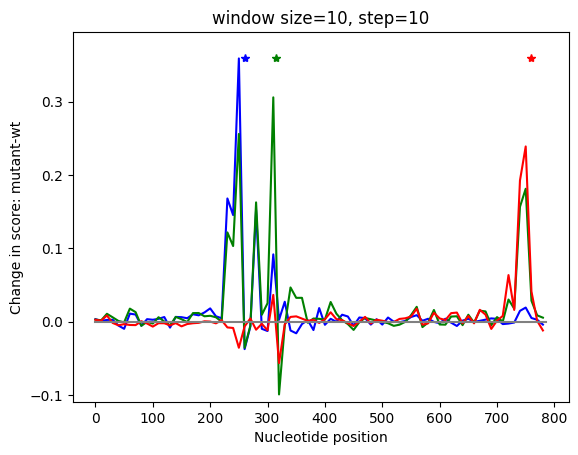

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
#@title Step 2: Scanning for regulatory elements
#@markdown Sequences in a sliding window will be set to N and the change in strength of each predicted splice site will be calculated and plotted.

Window_size = 10 #@param {type:"slider", min:1, max:100, step:1}


Step_size = 10 #@param {type:"slider", min:1, max:100, step:1}

# wt score
score0 = []
for pos in sites:
    score0.append(float(sites[pos].split('\t')[-1]))

# mutational scan
impact_score = np.zeros((int(len(seq)/Step_size)+1,len(sites)))
for i in range(0,len(seq),Step_size):
    impact_score[int(i/Step_size),] = score0 - mutation_score(seq,i,Window_size,sites)  
    print(i)

np.savetxt("impact_score.txt",impact_score, delimiter="\t")

## consider plotting as sequence logo. score for center bases
cols = 'bgrcmyk'*10
pos = list(sites.keys())
miny = np.min(impact_score)
maxy = np.max(impact_score)
for i in range(len(sites)):
  pylab.plot(range(0,len(seq),Step_size),impact_score[:,i],color=cols[i])
  pylab.plot(pos[i],maxy,'*',color=cols[i])
pylab.plot([0,len(seq)],[0,0],color='gray')
pylab.ylim(miny*1.1,maxy*1.1)
pylab.ylabel('Change in score: wild type - mutant')
pylab.xlabel('Nucleotide position')
pylab.title('window size='+str(Window_size)+', step='+str(Step_size))

pylab.savefig('mutational_scan.pdf')  
pylab.show()

# save and download data
os.system(f'zip res.zip *.pdf *.txt')
files.download(f"res.zip")

# About <a name="Instructions"></a>

**Applications**
* Identify potential splicing artifacts in plasmid reporters.


**Limitations**
* A gmail account is required to run Google Colab notebooks.
* This notebook was designed for analyzing a single sequence. 
* Only sequences of length 1-150,000 bases have been tested. Longer sequences may fail due to a lack of memory.
* The first run is slow due to the need to install the `Pangolin` package.  
* GPU may not be available and running the prediction on CPU will be significantly slower. 
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `res.zip`, right-click and select \"Download\".


**Bugs**
- If you encounter any bugs, please report the issue by emailing Xuebing Wu (xw2629 at cumc dot columbia dot edu)

**License**

* The source code of this notebook is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). See details of the license for Pangolin [here](https://github.com/tkzeng/Pangolin/blob/main/LICENSE).

**Acknowledgments**
- We thank the [Pangolin](https://doi.org/10.1186/s13059-022-02664-4) team for developing an excellent model and open sourcing the software. 

- This notebook is modeld after the [ColabFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).
